# Using trained anemoi models

The central artifact resulting from the training of an anemoi model is its inference checkpoint*. The checkpoint not only contains the model itself (pickled python object and weights), but also the graph on which the model operates and a rich metadata information that tells us about how the model was trained, what data was used, and more.

In this notebook, we will have a look at the content of a checkpoint and then generate some simple configuration files to launch a model inference run.


*_Contrary to a training checkpoint, an inference checkpoint does not contain training-related information, such as the optimizer's state._


## Introducing: anemoi-inference

A simple interface for running anemoi models is provided by the anemoi-inference package. We will have a look at some of its useful commands. For more information, have a look at the official [documentation](https://anemoi.readthedocs.io/projects/inference/en/latest/).

**NOTE**: anemoi-inference is one of the less mature components of anemoi - it is still undergoing frequent large changes and refactorings.


In [9]:
!anemoi-inference --help

usage: anemoi-inference [-h] [--version] [--debug] [--rich]
                        {couple,inspect,metadata,patch,requests,retrieve,run,sanitise,validate}
                        ...

positional arguments:
  {couple,inspect,metadata,patch,requests,retrieve,run,sanitise,validate}
                        commands:
    couple              Couple tasks based on a configuration file.
    inspect             Inspect the contents of a checkpoint file.
    metadata            Edit, remove, dump or load metadata from a checkpoint
                        file.
    patch               Patch a checkpoint file.
    requests            MARS request utility.
    retrieve            Used by prepml.
    run                 Run inference from a config yaml file.
    sanitise            Sanitise a checkpoint file.
    validate            Validate the virtual environment against a checkpoint
                        file.

options:
  -h, --help            show this help message and exit
  --version, -V   

There are several commands available, but we will only look at few of them.

## High-level checkpoint inspection

As mentioned earlier, we want to have a look at the model's checkpoint. For this, the `inspect` command is provided:

In [4]:
!anemoi-inference inspect --help

usage: anemoi-inference inspect [-h]
                                (--variables | --requirements | --datasets | --dump)
                                [--json] [--validate]
                                path

Inspect the contents of a checkpoint file.

positional arguments:
  path            Path to the checkpoint.

options:
  -h, --help      show this help message and exit
  --variables     List the training variables and their categories.
  --requirements  Print a Python's requirements.txt based on the versions of
                  the packages used during training.
  --datasets      Print the arguments passed to anemoi-dataset during
                  training.
  --dump          Dump information from the checkpoint.
  --json          Output in JSON format (with dump option)
  --validate      Validate the environment.


With this command, we can print information about the checkpoint in the terminal. Let's look at some examples.

### Variables

The command

```bash
anemoi-inference inspect --variables <checkpoint>
```

prints a summary of the variables used by the provided checkpoint. For each variable, we get some categories that help us understand how they are used by the model and how they can be provided to it:

- `prognostic` for atmospheric state variables that are both inputs and targets of the model
- `diagnostic` for variables that are only produced as targets
- `forcings` for variables that are only provided as inputs
- `accumulation` for accumulated quantities such as precipitation
- `constant` for fields that are constant in time
- `computed` for fields that are always the same for any time and location, and can therefore be computed



In [26]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

CHECKPOINT_PATH = PROJECT_ROOT / "output/training/checkpoint/dfa1cd5d30aa4a1db2aa7404f8a33e72/inference-last.ckpt"

!anemoi-inference inspect --variables {CHECKPOINT_PATH} 

/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/.venv/lib/python3.12/site-packages/anemoi/inference/legacy.py:41: UserWarning: Using legacy _legacy_variables_metadata, please try to patch your weights.
  warnings.warn(f"Using legacy {func.__name__}, please try to patch your weights.")
   10u            => prognostic
   10v            => prognostic
   2d             => prognostic
   2t             => prognostic
   cos_julian_day => computed, forcing
   cos_latitude   => computed, constant, forcing
   cos_local_time => computed, forcing
   cos_longitude  => computed, constant, forcing
   cp             => accumulation, diagnostic
   insolation     => computed, forcing
   lsm            => constant, forcing
   msl            => prognostic
   q_100          => prognostic
   q_1000         => prognostic
   q_150          => prognostic
   q_200          => prognostic
   q_250          => prognostic
   q_300          => prognostic
   q_400          => prognostic
   q_50           => pr

### Requirements

When distributing a model, it is critical that one is able to reproduce a runtime environment capable of running it. Therefore, the list of packages and their versions used in the training environment are stored in the checkpoint metadata. A simple command can be used to extract this information from the checkpoint in a format that can be directly written to a `requirements.txt` file.

In [27]:
!anemoi-inference inspect --requirements {CHECKPOINT_PATH} 

# This file is automatically generated from a checkpoint.
# Checkpoint: /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/training/checkpoint/dfa1cd5d30aa4a1db2aa7404f8a33e72/inference-last.ckpt
# Python: 3.12.6


# PyPI requirements:

Cartopy==0.25.0
Deprecated==1.2.18
GitPython==3.1.45
Jinja2==3.1.6
MarkupSafe==3.0.3
PyYAML==6.0.3
Pygments==2.19.2
anemoi-datasets==0.5.27
anemoi-graphs==0.7.0
anemoi-models==0.9.6
anemoi-transform==0.1.17
anemoi-utils==0.4.37
aniso8601==10.0.1
annotated-types==0.7.0
astropy==7.1.1
attrs==25.4.0
cachetools==6.2.1
certifi==2025.10.05
cftime==1.6.5
charset-normalizer==3.4.4
click==8.3.0
cloudpickle==3.1.1
cycler==0.12.1
dask==2025.10.0
datashader==0.18.2
decorator==5.2.1
distutils==3.12.6
einops==0.8.1
executing==2.2.1
filelock==3.20.0
fsspec==2025.9.0
gitdb==4.0.12
huggingface-hub==0.35.3
hydra-core==1.3.2
idna==3.11
ipython==9.6.0
jedi==0.19.2
joblib==1.5.2
kiwisolver==1.4.9
lightning-utilities==0.15.2
llvmlite==0.45.1
matplotlib==3.10.7
mlf

An additional `--validate` option can be used to check that the currently active environment is compatible with the one used for training. If the environment validation failed, we would see an error message like this:

```bash
2025-10-23 20:39:31 WARNING Environment validation failed. The following issues were found:
  critical mismatch:
    CRITICAL: Version of module anemoi.graphs was greater in training than in inference: 0.7.0 > 0.6.6
```

In [28]:
!anemoi-inference inspect --requirements --validate {CHECKPOINT_PATH} 

2025-10-23 21:23:23 WARNING Environment validation failed. The following issues were found:
  critical mismatch:
    CRITICAL: Version of module anemoi.graphs was greater in training than in inference: 0.7.0 > 0.6.6


### Datasets

We can also see which arguments were passed to the `open_dataset` function that was used during training. When the model has been trained on a single dataset and without additional preprocessing steps, this is not particularly important. However, operations to open a dataset can be quite complex, as seen in one of the previous notebooks, and one could even have trained a model on a combination of multiple datasets. 

Getting the exact declarative configuration to get the dataset makes it easier to run the model during inference.

In [29]:
!anemoi-inference inspect --datasets {CHECKPOINT_PATH} 

Open dataset arguments:

-   dataset: aifs-ea-an-oper-0001-mars-o96-1979-2022-6h-v6
    drop: []
    end: 2020
    frequency: 6h
    start: null



## Checkpoint metadata: read & edit

It is also possible to inspect the entire checkpoint metadata more in detail. 


Additionally, for if you know what you are doing, you can also edit the metadata. If you are executing this notebook in VSCode, uncomment and run the following block. A new editor panel will open where you can override some checkpoint metadata. When you close the panel, any change will be saved in the checkpoint. 

In [30]:
#!anemoi-inference metadata --edit {CHECKPOINT_PATH} --edit --editor=code

## Inference configuration

The main interface to run anemoi models is, you guessed it, via a YAML configuration file:

```bash
anemoi-inference run config.yaml
```

We will now generate two configurations: one to run the model from the dataset used for training (on an hold-out period), and one to run the model from GRIB data.

### Running the model from an anemoi-dataset

The simplest way 

In [ ]:
import yaml

config = {}

# first, we specify the checkpoint to use
config["checkpoint"] = str(CHECKPOINT_PATH)

# as input, we use the test split of the dataset used for training
# 'test' is a registered input type, just like 'grib' or 'mars'
config["input"] = {
    "test": {
        "use_original_paths": True,
    }
}

# as output, let's start by simply printing to the console
config["output"] = "printer"

# finally, we specify an initialization date for the forecasts
# it must be part of the test hold-out period
config["date"] = "2022-09-01T00:00"



config_dir = PROJECT_ROOT / "configs/inference"
config_dir.mkdir(parents=True, exist_ok=True)
config_path = config_dir / "dataset_to_printer.yaml"
with open(config_path, "w") as f:
    yaml.dump(config, f)

In this example we are running a fairly small model. You could even try running it from a personal computer with a good GPU, but here we will launch a SLURM job with `srun`.

In [36]:
# uncomment to run on Balfrin
!srun -p short -c120 -n1 -u --gres gpu:1 anemoi-inference run {config_path}

2025-10-23 21:32:25 INFO Pre processors: []
2025-10-23 21:32:25 INFO Post processors: []
2025-10-23 21:32:56 INFO Using DefaultRunner runner, device=cuda
/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/.venv/lib/python3.12/site-packages/anemoi/inference/legacy.py:41: UserWarning: Using legacy _legacy_variables_metadata, please try to patch your weights.
  warnings.warn(f"Using legacy {func.__name__}, please try to patch your weights.")
2025-10-23 21:32:56 INFO Output: PrinterOutput()
2025-10-23 21:32:56 INFO Loading `config.prognostic_input` from `config.input`
2025-10-23 21:32:57 INFO Prognostic input: DatasetInput([], {'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets//aifs-ea-an-oper-0001-mars-o96-1979-2022-6h-v6.zarr', 'start': 2022, 'end': None, 'frequency': '6h', 'drop': []})
2025-10-23 21:32:57 INFO 📥 Prognostic input: DatasetInput([], {'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets//aifs-ea-an-oper-0001

The whole program takes about 2 minutes to run, but the actual model execution took only a few seconds.

What if we write some output? 

In [48]:
out_dir = PROJECT_ROOT / "output/inference"
out_dir.mkdir(parents=True, exist_ok=True)

# note: we can format the output path of GRIB files using GRIB keys
config["output"] = {"grib": {"path": str(out_dir / "{dataDate}{dataTime}_{step}.grib")}}

config_path = config_dir / "dataset_to_grib.yaml"
with open(config_path, "w") as f:
    yaml.dump(config, f)

In [49]:
!srun -p short -c120 -n1 -u --gres gpu:1 anemoi-inference run {config_path}

2025-10-23 23:10:59 INFO Pre processors: []
2025-10-23 23:10:59 INFO Post processors: []
2025-10-23 23:11:27 INFO Using DefaultRunner runner, device=cuda
/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/.venv/lib/python3.12/site-packages/anemoi/inference/legacy.py:41: UserWarning: Using legacy _legacy_variables_metadata, please try to patch your weights.
  warnings.warn(f"Using legacy {func.__name__}, please try to patch your weights.")
2025-10-23 23:11:28 INFO Output: GribFileOutput(/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/inference/{dataDate}{dataTime}_{step}.grib)
2025-10-23 23:11:28 INFO Loading `config.prognostic_input` from `config.input`
2025-10-23 23:11:28 INFO Prognostic input: DatasetInput([], {'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets//aifs-ea-an-oper-0001-mars-o96-1979-2022-6h-v6.zarr', 'start': 2022, 'end': None, 'frequency': '6h', 'drop': []})
2025-10-23 23:11:28 INFO 📥 Prognostic input: DatasetInput([], 

In [52]:
import earthkit.data as ekd
import earthkit.plots as ekp

source = ekd.from_source("file", str(out_dir / "*_42.grib"))
source.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,q,isobaricInhPa,50,20220901,0,42,fc,None,reduced_gg
1,ecmf,q,isobaricInhPa,100,20220901,0,42,fc,None,reduced_gg
2,ecmf,q,isobaricInhPa,150,20220901,0,42,fc,None,reduced_gg
3,ecmf,q,isobaricInhPa,200,20220901,0,42,fc,None,reduced_gg
4,ecmf,q,isobaricInhPa,250,20220901,0,42,fc,None,reduced_gg
...,...,...,...,...,...,...,...,...,...,...
83,ecmf,skt,surface,0,20220901,0,42,fc,None,reduced_gg
84,ecmf,sp,surface,0,20220901,0,42,fc,None,reduced_gg
85,ecmf,tcw,entireAtmosphere,0,20220901,0,42,fc,None,reduced_gg
86,ecmf,cp,surface,0,20220901,0,36-42,fc,None,reduced_gg


/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/.venv/lib/python3.12/site-packages/earthkit/plots/quickplot.py:162: UserWarning: Failed to execute legend on given data with: 
module 'earthkit.plots.metadata' has no attribute 'units'

consider constructing the plot manually.
  warnings.warn(


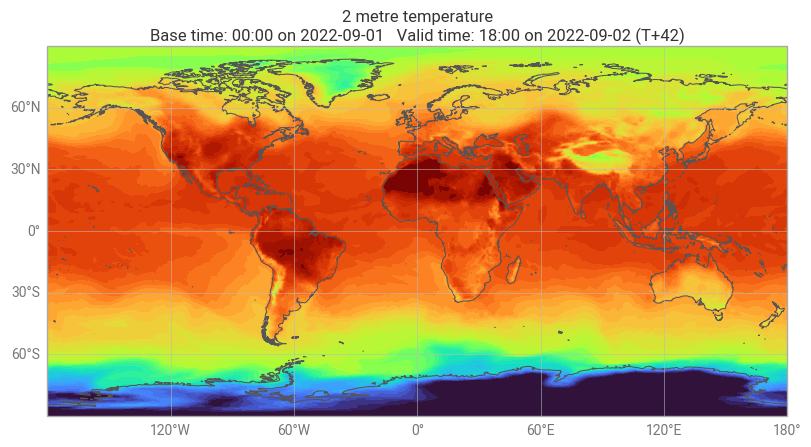

In [54]:
ekp.quickplot(source.sel(shortName="2t"))